# DDPM (Denoising Diffusion Probabilistic Models) with MNIST

https://arxiv.org/abs/2006.11239

In [ ]:
import copy
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader


# ----------------------------------------------------------------------
# Residual Block with Group Normalization
# ----------------------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()

        # Residual Block with Group Normalization
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(32, out_ch),
            nn.SiLU()
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(32, out_ch),
            nn.SiLU()
        )

        # MLP for time step
        self.time_mlp = nn.Linear(t_dim, out_ch)

        # Shortcut connection
        if in_ch != out_ch:
            # If input and output channels are different, use 1x1 convolution to adjust
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1)
        else:
            # If input and output channels are the same, use identity mapping
            self.shortcut = nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = self.block2(h)
        return h + self.shortcut(x)  # Add residual connection


# ----------------------------------------------------------------------
# Self-Attention Block
# ----------------------------------------------------------------------
class SelfAttention(nn.Module):
    def __init__(self, ch):
        super().__init__()

        # Self-Attention Block using 1x1 Convolutions
        # Q, K, V projections and output projection
        self.q = nn.Conv2d(ch, ch, 1)
        self.k = nn.Conv2d(ch, ch, 1)
        self.v = nn.Conv2d(ch, ch, 1)
        self.proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x):
        B, C, H, W = x.shape

        # Reshape and permute for attention calculation
        q = self.q(x).reshape(B, C, H*W).permute(0,2,1)   # (B, HW, C)
        k = self.k(x).reshape(B, C, H*W)                  # (B, C, HW)
        v = self.v(x).reshape(B, C, H*W).permute(0,2,1)   # (B, HW, C)

        attn = torch.bmm(q, k) / (C ** 0.5)               # (B, HW, HW)
        attn = attn.softmax(dim=-1)

        out = torch.bmm(attn, v)                          # (B, HW, C)
        out = out.permute(0,2,1).reshape(B, C, H, W)
        out = self.proj(out)

        return out + x  # Add residual connection


# ----------------------------------------------------------------------
# Encoder Block (Downsampling)
# ----------------------------------------------------------------------
class Encode(nn.Module):
    def __init__(self, in_ch, out_ch, t_emb_dim, atten=False, down=True):
        super().__init__()
 
        self.block1 = ResidualBlock(in_ch, out_ch, t_emb_dim)
        self.block2 = ResidualBlock(out_ch, out_ch, t_emb_dim)
        self.atten  = SelfAttention(out_ch) if atten else nn.Identity()
        self.down   = nn.Conv2d(out_ch, out_ch, 3, 2, 1) \
            if down else nn.Identity()

    def forward(self, x, t_emb):
        x = self.block1(x, t_emb)
        x = self.block2(x, t_emb)
        x = self.atten(x)
        return self.down(x), x  # For concatenation in upsampling


# ----------------------------------------------------------------------
# Decoder Block (Upsampling)
# ----------------------------------------------------------------------
class Decode(nn.Module):
    def __init__(self, in_ch, out_ch, t_emb_dim, atten=False):
        super().__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_ch, out_ch, 3, padding=1)  # Upsampling
        )
        self.block1 = ResidualBlock(out_ch*2, out_ch, t_emb_dim)
        self.block2 = ResidualBlock(out_ch, out_ch, t_emb_dim)
        self.atten  = SelfAttention(out_ch) if atten else nn.Identity()

    def forward(self, x, t_emb, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)  # Skip connection from encoder
        x = self.block1(x, t_emb)
        x = self.block2(x, t_emb)
        x = self.atten(x)
        return x


# ----------------------------------------------------------------------
# Sinusoidal Time Encoding
# ----------------------------------------------------------------------
def sinusoidal_time_encoding(t: torch.Tensor, dim: int) -> torch.Tensor:
    # dim must be even
    half_dim = dim // 2

    # Indices along the embedding dimension
    indices = torch.arange(half_dim, dtype=torch.float32, device=t.device)

    # Calculate scales based on indices
    scales = torch.exp(-math.log(10000.0) * indices / (half_dim - 1))

    # Scale time steps (equivalent to angles in the sinusoidal function)
    angles = t[:, None].float() * scales[None, :]

    # Sinusoidal encoding of time steps
    enc = torch.zeros(t.shape[0], dim, device=t.device)
    enc[:, 0::2] = torch.sin(angles)
    enc[:, 1::2] = torch.cos(angles)
    return enc



# ----------------------------------------------------------------------
# Time Embedding MLP
# ----------------------------------------------------------------------
class TimeEmbedding(nn.Module):
    def __init__(self, t_dim):
        super().__init__()
        self.t_dim = t_dim
        self.mlp = nn.Sequential(
            nn.Linear(t_dim, t_dim * 4),
            nn.SiLU(),
            nn.Linear(t_dim * 4, t_dim),
        )

    def forward(self, t):
        emb = sinusoidal_time_encoding(t, self.t_dim)
        return self.mlp(emb)


# ----------------------------------------------------------------------
# U-Net Architecture Definition
# ----------------------------------------------------------------------
class UNet(nn.Module):
    def __init__(self, image_ch: int, base_ch: int, t_dim: int):
        super().__init__()

        # Time step embedding
        self.time_mlp = TimeEmbedding(t_dim)

        # Encoder
        self.enc1 = Encode(image_ch , base_ch  , t_dim)
        self.enc2 = Encode(base_ch  , base_ch*2, t_dim, atten=True)
        self.enc3 = Encode(base_ch*2, base_ch*2, t_dim)

        # Bottleneck
        self.neck = Encode(base_ch*2, base_ch*2, t_dim, down=False)

        # Decoder
        self.dec1 = Decode(base_ch*2, base_ch*2, t_dim)
        self.dec2 = Decode(base_ch*2, base_ch*2, t_dim, atten=True)
        self.dec3 = Decode(base_ch*2, base_ch  , t_dim)

        # Output
        self.out_conv = nn.Conv2d(base_ch, image_ch, 1)

    def forward(self, x, t):
        # Time step embedding
        t_emb = self.time_mlp(t)

        # Encoder
        x, skip1 = self.enc1(x, t_emb)
        x, skip2 = self.enc2(x, t_emb)
        x, skip3 = self.enc3(x, t_emb)

        # Bottleneck
        x, _ = self.neck(x, t_emb)

        # Decoder
        x = self.dec1(x, t_emb, skip3)
        x = self.dec2(x, t_emb, skip2)
        x = self.dec3(x, t_emb, skip1)

        return self.out_conv(x)

## Forward and Backward Processes

In [ ]:
# ----------------------------------------------------------------------
# Choose device for computation
# ----------------------------------------------------------------------
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")
print(f"Using device: {device}")


# ----------------------------------------------------------------------
# Diffusion Schedule
# ----------------------------------------------------------------------
T = 1000     # Number of time steps
beta_start = 1e-4
beta_end = 0.02

betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)  # 累積積


# ----------------------------------------------------------------------
# Forward process Q(x_t | x_0) from the diffusion process
# ----------------------------------------------------------------------
def sample_q(
    x_0: torch.Tensor,  # Image data (batch, channels, height, width)
    t: torch.Tensor,    # Time step (tensor for batch size)
):
    # Generate noise with the same shape as the image data x_0
    epsilon = torch.randn_like(x_0)

    # Get alpha_bar corresponding to t (reshaped to 4D tensor)
    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)

    # Generate image with added noise
    x_t = (alpha_bar_t.sqrt() * x_0 + (1 - alpha_bar_t).sqrt() * epsilon)

    # Return noise as label
    return x_t, epsilon


# ----------------------------------------------------------------------
# Reverse process sampling from the generative model P_θ(x_{t-1} | x_t)
# ----------------------------------------------------------------------
def sample_p(
    x_t: torch.Tensor,  # Noisy image (batch, channels, height, width)
    t: torch.Tensor,    # Time step (tensor for batch size)
    noise_pred: torch.Tensor  # Model noise prediction (batch, channels, height, width)
):
    # Get alpha_bar and beta corresponding to t (reshaped to 4D tensor)
    beta = betas[t].view(-1, 1, 1, 1)
    alpha = alphas[t].view(-1, 1, 1, 1)
    s1_ab = torch.sqrt(1 - alpha_bars[t]).view(-1, 1, 1, 1)

    # Calculate mean
    mean = (1 / torch.sqrt(alpha)) * (x_t - beta / s1_ab * noise_pred)

    # At step 0, no noise is added (deterministic output)
    mask = (t != 0).float().view(-1, 1, 1, 1)

    # Add sampling noise
    noise = torch.randn_like(x_t)
    return mean + torch.sqrt(beta) * noise * mask


# ----------------------------------------------------------------------
# Sampling function (image generation)
# ----------------------------------------------------------------------
def sample(model: nn.Module, x: torch.Tensor):
    # x is the noisy image (batch, channels, height, width)
    n_samples = x.shape[0]

    # Sample time steps in reverse order
    for t_step in reversed(range(T)):
        # Convert time step to tensor
        t = torch.full((n_samples,), t_step, device=x.device, dtype=torch.long)

        # Perform noise prediction
        noise_pred = model(x, t)

        # Sample next step image from the generative process
        x = sample_p(x, t, noise_pred)
    return x


# ----------------------------------------------------------------------
# Function to display images in a grid format
# ----------------------------------------------------------------------
def show_images(samples, n_images_per_row: int=None):
    if n_images_per_row is None:
        n_images_per_row = samples.shape[0]  # Default is the number of samples

    # Normalize image values to range [0, 1]
    samples = (samples + 1) / 2  # [-1, 1] -> [0, 1]
    samples = samples.clamp(0, 1)  # Clip to [0, 1] range
    samples = samples.cpu()

    # Create a tensor for displaying in grid format
    grid = utils.make_grid(samples, nrow=n_images_per_row)

    # (B, C, H, W) -> (B, H, W, C)
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Using device: cuda


## Training Loop

Epoch 1/200, Loss: 0.0218
Epoch 2/200, Loss: 0.0250
Epoch 3/200, Loss: 0.0152
Epoch 4/200, Loss: 0.0223
Epoch 5/200, Loss: 0.0165
Epoch 6/200, Loss: 0.0212
Epoch 7/200, Loss: 0.0206
Epoch 8/200, Loss: 0.0150
Epoch 9/200, Loss: 0.0169
Epoch 10/200, Loss: 0.0126


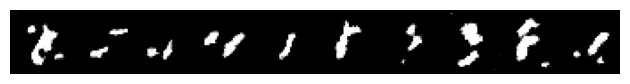

Epoch 11/200, Loss: 0.0153
Epoch 12/200, Loss: 0.0159
Epoch 13/200, Loss: 0.0169
Epoch 14/200, Loss: 0.0158
Epoch 15/200, Loss: 0.0161
Epoch 16/200, Loss: 0.0202
Epoch 17/200, Loss: 0.0151
Epoch 18/200, Loss: 0.0134
Epoch 19/200, Loss: 0.0151
Epoch 20/200, Loss: 0.0154


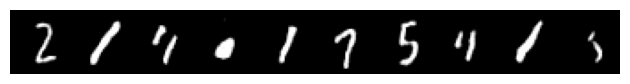

Epoch 21/200, Loss: 0.0143
Epoch 22/200, Loss: 0.0146
Epoch 23/200, Loss: 0.0158
Epoch 24/200, Loss: 0.0107
Epoch 25/200, Loss: 0.0142
Epoch 26/200, Loss: 0.0175
Epoch 27/200, Loss: 0.0180
Epoch 28/200, Loss: 0.0134
Epoch 29/200, Loss: 0.0200
Epoch 30/200, Loss: 0.0172


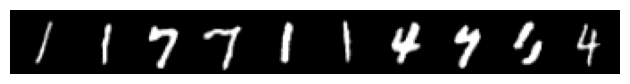

Epoch 31/200, Loss: 0.0161
Epoch 32/200, Loss: 0.0132
Epoch 33/200, Loss: 0.0147
Epoch 34/200, Loss: 0.0176
Epoch 35/200, Loss: 0.0152
Epoch 36/200, Loss: 0.0141
Epoch 37/200, Loss: 0.0147
Epoch 38/200, Loss: 0.0175
Epoch 39/200, Loss: 0.0131
Epoch 40/200, Loss: 0.0139


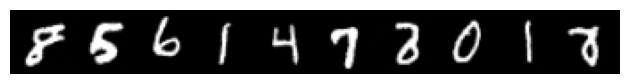

Epoch 41/200, Loss: 0.0114
Epoch 42/200, Loss: 0.0141
Epoch 43/200, Loss: 0.0157
Epoch 44/200, Loss: 0.0135
Epoch 45/200, Loss: 0.0194
Epoch 46/200, Loss: 0.0107
Epoch 47/200, Loss: 0.0137
Epoch 48/200, Loss: 0.0141
Epoch 49/200, Loss: 0.0140
Epoch 50/200, Loss: 0.0153


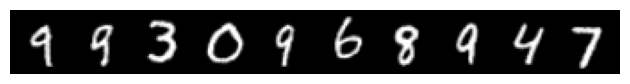

Epoch 51/200, Loss: 0.0127
Epoch 52/200, Loss: 0.0126
Epoch 53/200, Loss: 0.0123
Epoch 54/200, Loss: 0.0117
Epoch 55/200, Loss: 0.0123
Epoch 56/200, Loss: 0.0118
Epoch 57/200, Loss: 0.0113
Epoch 58/200, Loss: 0.0163
Epoch 59/200, Loss: 0.0128
Epoch 60/200, Loss: 0.0121


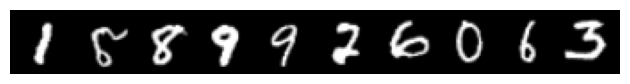

Epoch 61/200, Loss: 0.0189
Epoch 62/200, Loss: 0.0152
Epoch 63/200, Loss: 0.0196
Epoch 64/200, Loss: 0.0175
Epoch 65/200, Loss: 0.0161
Epoch 66/200, Loss: 0.0126
Epoch 67/200, Loss: 0.0154
Epoch 68/200, Loss: 0.0124
Epoch 69/200, Loss: 0.0134
Epoch 70/200, Loss: 0.0174


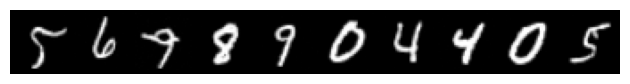

Epoch 71/200, Loss: 0.0138
Epoch 72/200, Loss: 0.0128
Epoch 73/200, Loss: 0.0105
Epoch 74/200, Loss: 0.0109
Epoch 75/200, Loss: 0.0148
Epoch 76/200, Loss: 0.0164
Epoch 77/200, Loss: 0.0147
Epoch 78/200, Loss: 0.0137
Epoch 79/200, Loss: 0.0108
Epoch 80/200, Loss: 0.0133


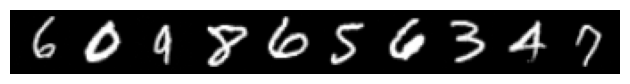

Epoch 81/200, Loss: 0.0146
Epoch 82/200, Loss: 0.0137
Epoch 83/200, Loss: 0.0126
Epoch 84/200, Loss: 0.0171
Epoch 85/200, Loss: 0.0147
Epoch 86/200, Loss: 0.0095
Epoch 87/200, Loss: 0.0109
Epoch 88/200, Loss: 0.0155
Epoch 89/200, Loss: 0.0132
Epoch 90/200, Loss: 0.0120


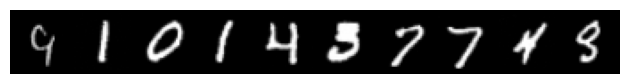

Epoch 91/200, Loss: 0.0144
Epoch 92/200, Loss: 0.0171
Epoch 93/200, Loss: 0.0152
Epoch 94/200, Loss: 0.0106
Epoch 95/200, Loss: 0.0128
Epoch 96/200, Loss: 0.0167
Epoch 97/200, Loss: 0.0120
Epoch 98/200, Loss: 0.0145
Epoch 99/200, Loss: 0.0148
Epoch 100/200, Loss: 0.0185


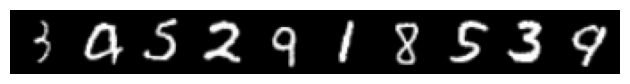

Epoch 101/200, Loss: 0.0171
Epoch 102/200, Loss: 0.0130
Epoch 103/200, Loss: 0.0122
Epoch 104/200, Loss: 0.0133
Epoch 105/200, Loss: 0.0145
Epoch 106/200, Loss: 0.0122
Epoch 107/200, Loss: 0.0077
Epoch 108/200, Loss: 0.0126
Epoch 109/200, Loss: 0.0131
Epoch 110/200, Loss: 0.0115


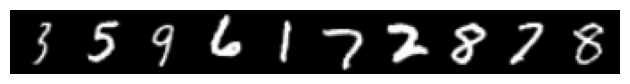

Epoch 111/200, Loss: 0.0155
Epoch 112/200, Loss: 0.0176
Epoch 113/200, Loss: 0.0116
Epoch 114/200, Loss: 0.0134
Epoch 115/200, Loss: 0.0159
Epoch 116/200, Loss: 0.0132
Epoch 117/200, Loss: 0.0170
Epoch 118/200, Loss: 0.0126
Epoch 119/200, Loss: 0.0140
Epoch 120/200, Loss: 0.0142


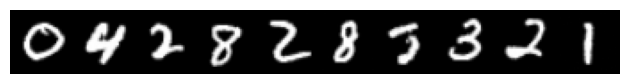

Epoch 121/200, Loss: 0.0162
Epoch 122/200, Loss: 0.0141
Epoch 123/200, Loss: 0.0131
Epoch 124/200, Loss: 0.0101
Epoch 125/200, Loss: 0.0115
Epoch 126/200, Loss: 0.0143
Epoch 127/200, Loss: 0.0135
Epoch 128/200, Loss: 0.0118
Epoch 129/200, Loss: 0.0138
Epoch 130/200, Loss: 0.0164


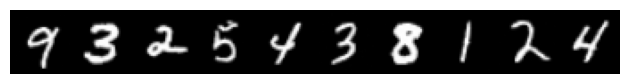

Epoch 131/200, Loss: 0.0121
Epoch 132/200, Loss: 0.0099
Epoch 133/200, Loss: 0.0152
Epoch 134/200, Loss: 0.0092
Epoch 135/200, Loss: 0.0140
Epoch 136/200, Loss: 0.0163
Epoch 137/200, Loss: 0.0205
Epoch 138/200, Loss: 0.0141
Epoch 139/200, Loss: 0.0114
Epoch 140/200, Loss: 0.0150


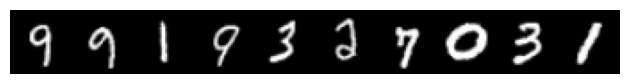

Epoch 141/200, Loss: 0.0140
Epoch 142/200, Loss: 0.0149
Epoch 143/200, Loss: 0.0105
Epoch 144/200, Loss: 0.0131
Epoch 145/200, Loss: 0.0170
Epoch 146/200, Loss: 0.0124
Epoch 147/200, Loss: 0.0101
Epoch 148/200, Loss: 0.0112
Epoch 149/200, Loss: 0.0137
Epoch 150/200, Loss: 0.0120


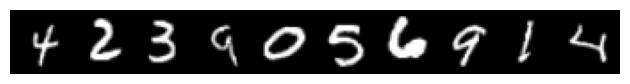

Epoch 151/200, Loss: 0.0159
Epoch 152/200, Loss: 0.0110
Epoch 153/200, Loss: 0.0135
Epoch 154/200, Loss: 0.0140
Epoch 155/200, Loss: 0.0126
Epoch 156/200, Loss: 0.0154
Epoch 157/200, Loss: 0.0126
Epoch 158/200, Loss: 0.0106
Epoch 159/200, Loss: 0.0117
Epoch 160/200, Loss: 0.0124


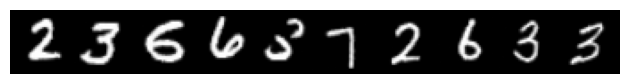

Epoch 161/200, Loss: 0.0138
Epoch 162/200, Loss: 0.0132
Epoch 163/200, Loss: 0.0130
Epoch 164/200, Loss: 0.0153
Epoch 165/200, Loss: 0.0155
Epoch 166/200, Loss: 0.0116
Epoch 167/200, Loss: 0.0140
Epoch 168/200, Loss: 0.0109
Epoch 169/200, Loss: 0.0104
Epoch 170/200, Loss: 0.0153


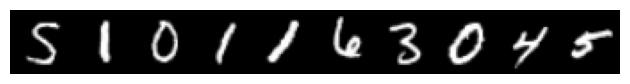

Epoch 171/200, Loss: 0.0142
Epoch 172/200, Loss: 0.0135
Epoch 173/200, Loss: 0.0168
Epoch 174/200, Loss: 0.0131
Epoch 175/200, Loss: 0.0147
Epoch 176/200, Loss: 0.0136
Epoch 177/200, Loss: 0.0125
Epoch 178/200, Loss: 0.0133
Epoch 179/200, Loss: 0.0156
Epoch 180/200, Loss: 0.0116


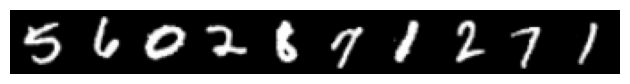

Epoch 181/200, Loss: 0.0173
Epoch 182/200, Loss: 0.0128
Epoch 183/200, Loss: 0.0160
Epoch 184/200, Loss: 0.0114
Epoch 185/200, Loss: 0.0130
Epoch 186/200, Loss: 0.0110
Epoch 187/200, Loss: 0.0123
Epoch 188/200, Loss: 0.0141
Epoch 189/200, Loss: 0.0095
Epoch 190/200, Loss: 0.0130


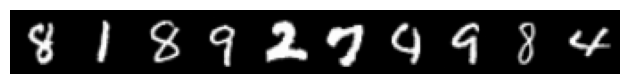

Epoch 191/200, Loss: 0.0155
Epoch 192/200, Loss: 0.0122
Epoch 193/200, Loss: 0.0115
Epoch 194/200, Loss: 0.0116
Epoch 195/200, Loss: 0.0117
Epoch 196/200, Loss: 0.0138
Epoch 197/200, Loss: 0.0133
Epoch 198/200, Loss: 0.0147
Epoch 199/200, Loss: 0.0149
Epoch 200/200, Loss: 0.0119


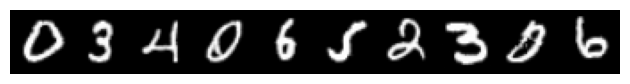

In [ ]:
# ----------------------------------------------------------------------
# Hyperparameters and Training Settings
# ----------------------------------------------------------------------
image_ch       = 1
image_size     = 32       # Resize  28x28 => 32x32
base_ch        = 64
t_dim          = 128
epochs         = 200
batch_size     = 128


# ----------------------------------------------------------------------
# MNIST dataset loading and DataLoader setup
# ----------------------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),  # Resize
    transforms.Lambda(lambda x: x * 2 -1)
])
dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# ----------------------------------------------------------------------
# UNet model initialization and optimizer setup
# ----------------------------------------------------------------------
model = UNet(image_ch, base_ch, t_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# ----------------------------------------------------------------------
# EMA model setup
# ----------------------------------------------------------------------
ema_model = copy.deepcopy(model)
ema_model.eval()  # Set to evaluation mode
ema_decay = 0.9999

# ----------------------------------------------------------------------
# Training loop
# ----------------------------------------------------------------------
for epoch in range(1,epochs+1):
    for x_0, _ in dataloader:
        # Transfer image data to device
        x_0 = x_0.to(device)

        # Generate noisy image from random time step
        t = torch.randint(0, T, (x_0.size(0),), device=device)
        x_t, epsilon = sample_q(x_0, t)  # Return noise as label

        # Perform noise prediction and calculate loss
        noise_pred = model(x_t, t)
        loss = F.mse_loss(noise_pred, epsilon)

        # Calculate gradients and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update EMA model
        with torch.no_grad():
            for ema_param, param in zip(ema_model.parameters(),
                                        model.parameters()):
                ema_param.data.mul_(ema_decay).add_(param.data, alpha=1 - ema_decay)

    print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

    if epoch % 10 == 0 or epoch == epochs:
        # Generate and display sample images during training
        with torch.no_grad():
            # Generate images from noisy images
            noise = torch.randn(10, image_ch, image_size, image_size).to(device)
            samples = sample(ema_model, noise)
        show_images(samples)

        # Save EMA model
        model_path = f'DDPM-MNIST-{epoch:03d}.pth'  # Model save path
        torch.save(ema_model.state_dict(), model_path)

## 100 Generated MNIST Images

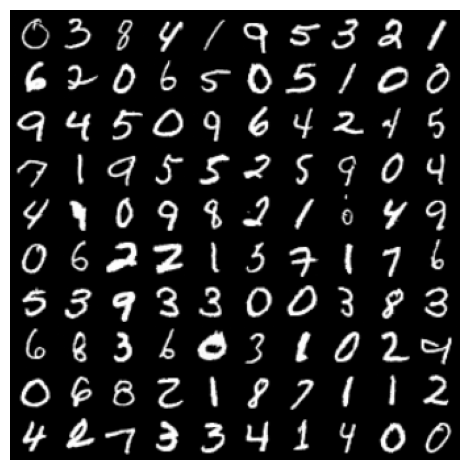

In [ ]:

# Trained model loading and image generation
model = UNet(image_ch, base_ch, t_dim).to(device)
model.load_state_dict(torch.load("DDPM-MNIST-200.pth", map_location=device))

# Use trained model to generate images
model.eval()
with torch.no_grad():
    # Generate images from noisy images
    noise = torch.randn(100, image_ch, image_size, image_size).to(device)
    samples = sample(model, noise)
show_images(samples, 10)

    

## Compare with Real MNIST images

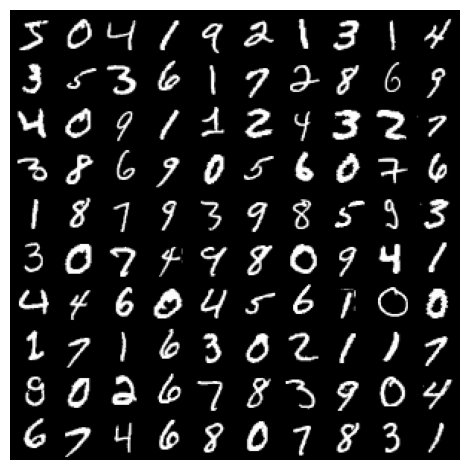

In [ ]:
# Display first 100 images from the dataset for comparison
grid = utils.make_grid(dataset.data[:100].unsqueeze(1), nrow=10, padding=2)
plt.imshow(grid.permute(1, 2, 0).numpy())  # (B, C, H, W) -> (B, H, W, C)
plt.axis('off')
plt.tight_layout()
plt.show()